<a href="https://colab.research.google.com/github/LapTQ/surface_defect_detection/blob/main/surface_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets:
* Detection
 * [Steel Surface: NEU-CLS](http://faculty.neu.edu.cn/songkc/en/zdylm/263265/list/index.htm)
 * [DeepPBC](https://github.com/Charmve/Surface-Defect-Detection/tree/master/DeepPCB)
* Segmenation
 * [Severstal: Steel Defect Detection](https://www.kaggle.com/c/severstal-steel-defect-detection/overview)
 * [AITEX FABRIC IMAGE DATABASE](https://www.aitex.es/afid/)

In [1]:
!git clone https://github.com/LapTQ/surface_defect_detection.git

Cloning into 'surface_defect_detection'...
remote: Enumerating objects: 3634, done.
remote: Counting objects: 100% (3634/3634), done.
remote: Compressing objects: 100% (1920/1920), done.
remote: Total 3634 (delta 1721), reused 3603 (delta 1710), pack-reused 0
Receiving objects: 100% (3634/3634), 25.65 MiB | 20.15 MiB/s, done.
Resolving deltas: 100% (1721/1721), done.


In [ ]:
# !cp /content/surface_defect_detection/NEU-DET/IMAGES /content/

In [2]:
!git clone https://github.com/ultralytics/yolov5
# !pip install -r yolov5/requirements.txt

# %cd /content/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 11212, done.
remote: Total 11212 (delta 0), reused 0 (delta 0), pack-reused 11212
Receiving objects: 100% (11212/11212), 11.16 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (7753/7753), done.


In [3]:
import torch
from IPython.display import Image # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
# from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# from utils.google_utils import gdrive_download # for downloading models/datasets

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [4]:
!cat surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml

<annotation>
	<folder>cr</folder>
	<filename>crazing_2.jpg</filename>
	<source>
		<database>NEU-DET</database>
	</source>
	<size>
		<width>200</width>
		<height>200</height>
		<depth>1</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>99</xmin>
			<ymin>120</ymin>
			<xmax>200</xmax>
			<ymax>174</ymax>
		</bndbox>
	</object>
	<object>
		<name>crazing</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>16</ymin>
			<xmax>200</xmax>
			<ymax>111</ymax>
		</bndbox>
	</object>
</annotation>


In [4]:
def extract_info_from_xml(xml_file):
    xml_root = ET.parse(xml_file).getroot()

    info = {}
    info['bboxes'] = []
    info['image_size'] = []

    for element in xml_root:
        # get image file name
        if element.tag == 'filename':
            info['filename'] = element.text

        # get image size
        if element.tag == 'size':
            for sub_element in element:
                info['image_size'].append(int(sub_element.text))
        
        # get bounding boxes
        if element.tag == 'object':
            bbox = {}
            for sub_element in element:
                if sub_element.tag == 'name':
                    bbox['class'] = sub_element.text
                elif sub_element.tag == 'bndbox':
                    for sub_sub_element in sub_element:
                        bbox[sub_sub_element.tag] = int(sub_sub_element.text)
            info['bboxes'].append(bbox)
    return info

In [6]:
extract_info_from_xml('surface_defect_detection/NEU-DET/ANNOTATIONS/crazing_2.xml')

{'bboxes': [{'class': 'crazing',
   'xmax': 200,
   'xmin': 99,
   'ymax': 174,
   'ymin': 120},
  {'class': 'crazing', 'xmax': 200, 'xmin': 8, 'ymax': 111, 'ymin': 16}],
 'filename': 'crazing_2.jpg',
 'image_size': [200, 200, 1]}

In [5]:
from pathlib import Path

In [6]:
def get_class_name(annotations_dir):
    class_name = set()
    annotations_dir = Path(annotations_dir)
    for xml_path in annotations_dir.glob('*.xml'):
        info = extract_info_from_xml(xml_path)
        for bbox in info['bboxes']:
            class_name.add(bbox['class'])
    return class_name
    
class_name = get_class_name('surface_defect_detection/NEU-DET/ANNOTATIONS')

# TODO
class_name_to_id_mapping = {
    'crazing': 0,
    'inclusion': 1,
    'patches': 2,
    'pitted_surface': 3,
    'rolled-in_scale': 4,
    'scratches': 5
}

class_id_to_name_mapping = dict(zip(
    class_name_to_id_mapping.values(),
    class_name_to_id_mapping.keys(),
))


In [7]:
!mkdir dataset
!mkdir dataset/annotations
!cp -r surface_defect_detection/NEU-DET/IMAGES /content/dataset/images

In [8]:
def convert_to_yolov5(info):
    buffer = []

    for bbox in info['bboxes']:
        try:
            class_id = class_name_to_id_mapping[bbox['class']]
        except KeyError:
            print('Invalid class. Must be one from', class_name_to_id_mapping)

        # convert to [x, y, w, h]
        bx = (bbox['xmin'] + bbox['xmax']) / 2
        by = (bbox['ymin'] + bbox['ymax']) / 2
        bw = (bbox['xmax'] - bbox['xmin'])
        bh = (bbox['ymax'] - bbox['ymin'])

        # normalize bbox dimensions
        image_w, image_h, image_c = info['image_size']
        bx /= image_w
        by /= image_h
        bw /= image_w
        bh /= image_h

        buffer.append('{} {:3f} {:3f} {:3f} {:3f}'.format(class_id, bx, by, bw, bh))
    
    save_filename = os.path.join('dataset/annotations', info['filename'].replace('.jpg', '') + '.txt')
    print('\n'.join(buffer), file=open(save_filename, 'w'))

In [9]:
for ann in Path('surface_defect_detection/NEU-DET/ANNOTATIONS').glob('*.xml'):
    info = extract_info_from_xml(ann)
    convert_to_yolov5(info)

In [12]:
!cat /content/dataset/annotations/crazing_2.txt

0 0.747500 0.735000 0.505000 0.270000
0 0.520000 0.317500 0.960000 0.475000


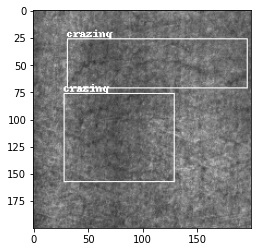

In [10]:
def plot_bbox(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_img = ImageDraw.Draw(image)

    transformed_ann = np.copy(annotations)
    transformed_ann[:, [1, 3]] = annotations[:, [1, 3]] * w
    transformed_ann[:, [2, 4]] = annotations[:, [2, 4]] * h
    
    transformed_ann[:, 1] -= transformed_ann[:, 3] / 2
    transformed_ann[:, 2] -= transformed_ann[:, 4] / 2
    transformed_ann[:, 3] += transformed_ann[:, 1]
    transformed_ann[:, 4] += transformed_ann[:, 2]

    for ann in transformed_ann:
        class_id, xmin, ymin, xmax, ymax = ann
        plotted_img.rectangle(((xmin, ymin), (xmax, ymax)))
        plotted_img.text((xmin, ymin - 10), class_id_to_name_mapping[class_id])
    
    plt.imshow(np.array(image))
    plt.show()

# show an example
annotation_file = random.choice(list(Path('dataset/annotations').glob('*.txt')))
with open(annotation_file, 'r') as file:
    annotation_list = file.read().split('\n')[:-1]
    annotation_list = [_.split() for _ in annotation_list]
    annotation_list = [[float(_) for _ in __] for __ in annotation_list]

image = Image.open(str(annotation_file).replace('annotations', 'images').replace('txt', 'jpg'))
plot_bbox(image, annotation_list)

In [11]:
annotations = [str(_) for _ in Path('dataset/annotations').glob('*.txt')]
images = [_.replace('annotations', 'images').replace('txt', 'jpg') for _ in annotations]

train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.3, random_state=42)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size=0.5, random_state=42)

In [12]:
!mkdir dataset/images/train dataset/images/val dataset/images/test dataset/annotations/train dataset/annotations/val dataset/annotations/test

In [13]:
def move_files_to_folder(file_list, destination_folder):
    for f in file_list:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

move_files_to_folder(train_images, 'dataset/images/train')
move_files_to_folder(val_images, 'dataset/images/val')
move_files_to_folder(test_images, 'dataset/images/test')
move_files_to_folder(train_annotations, 'dataset/annotations/train')
move_files_to_folder(val_annotations, 'dataset/annotations/val')
move_files_to_folder(test_annotations, 'dataset/annotations/test')

https://blog.paperspace.com/train-yolov5-custom-data/